In [1]:
!pip install -U imbalanced-learn

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2022)

In [71]:
# Sample Data
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=300, shuffle=True, noise=0.5, random_state=2022)

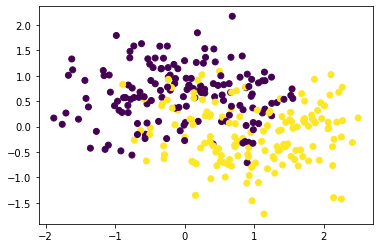

In [72]:
plt.scatter(data[:, 0], data[:, 1], c=label)

In [73]:
# Resample Data
# 한 쪽 데이터의 비율을 줄여서 이상 데이터를 생성
from imblearn.datasets import make_imbalance
from collections import Counter

# 적은 class를 얼마나 줄일지에 대한 함수
def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

data, label = make_imbalance(
    data,
    label,
    sampling_strategy=ratio_func,
    **{"multiplier": 0.1, "minority_class": 1,}
)

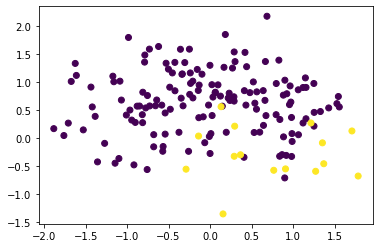

In [74]:
plt.scatter(data[:, 0], data[:, 1], c=label)

In [75]:
pd.Series(label).value_counts()

0    150
1     15
dtype: int64

In [76]:
# Data Split
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(
    data, label, train_size=0.7, random_state=2022, stratify=label
)

In [77]:
train_label.mean()

0.08695652173913043

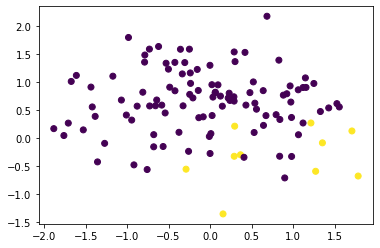

In [78]:
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_label)

In [79]:
test_label.mean()

0.1

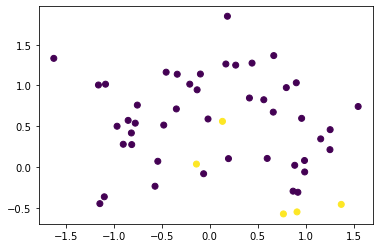

In [80]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_label)

In [81]:
# 시각화 데이터
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

In [82]:
# Model - Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

In [83]:
# 학습
tree.fit(train_data, train_label)

DecisionTreeClassifier()

In [84]:
# 예측
tree_train_pred = tree.predict(train_data)
tree_test_pred = tree.predict(test_data)

In [85]:
# 평가
# 정확도
from sklearn.metrics import accuracy_score

tree_train_acc = accuracy_score(train_label, tree_train_pred)
tree_test_acc = accuracy_score(test_label, tree_test_pred)

In [86]:
print(f"Tree train accuray is {tree_train_acc:.4f}")
print(f"Tree test accuray is {tree_test_acc:.4f}")   

Tree train accuray is 1.0000
Tree test accuray is 0.9200


In [87]:
# F1 Score
from sklearn.metrics import f1_score

tree_train_f1 = f1_score(train_label, tree_train_pred)
tree_test_f1 = f1_score(test_label, tree_test_pred)

In [88]:
print(f"Tree train F1-Score is {tree_train_f1:.4f}")
print(f"Tree test F1-Score is {tree_test_f1:.4f}")   

Tree train F1-Score is 1.0000
Tree test F1-Score is 0.6000


In [89]:
# 시각화
tree_Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
tree_Z = tree_Z.reshape(xx.shape)

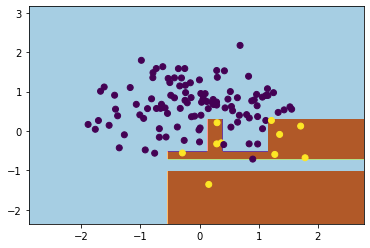

In [90]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)

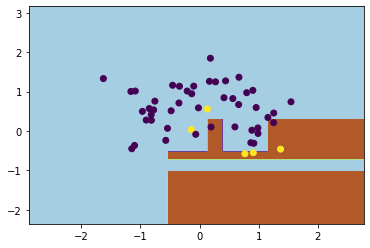

In [91]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:,0], test_data[:,1], c=test_label)
# 2개의 노란색 점(이상치)이 Decision boundary 밖으로 나옴

In [92]:
# Under Sampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss

under_dict = {}

rus = RandomUnderSampler(random_state=2021)
rus_data, rus_label = rus.fit_resample(train_data, train_label)
under_dict["rus"] = {"data": rus_data, "label": rus_label}

In [93]:
for i in range(1, 4):
    near_miss = NearMiss(version=i)
    near_data, near_label = near_miss.fit_resample(train_data, train_label)
    under_dict[f"near_{i}"] = {
        "data": near_data, "label": near_label
    }

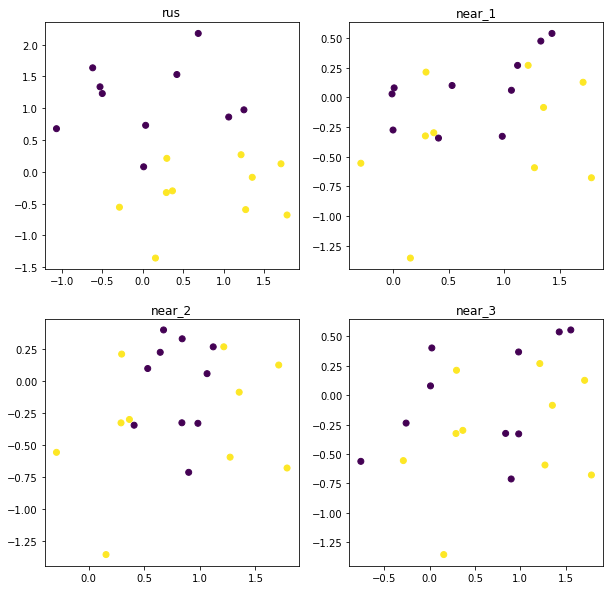

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, sample) in enumerate(under_dict.items()):
    ax = axes[idx//2, idx%2]
    d, l = sample["data"], sample["label"]
    ax.scatter(d[:, 0], d[:, 1], c=l)
    ax.set_title(name)

In [95]:
# 학습
under_model = {}
for name, sample in under_dict.items():
    under_tree = DecisionTreeClassifier()
    under_tree.fit(sample["data"], sample["label"])
    under_model[name] = under_tree

In [96]:
under_model

{'rus': DecisionTreeClassifier(),
 'near_1': DecisionTreeClassifier(),
 'near_2': DecisionTreeClassifier(),
 'near_3': DecisionTreeClassifier()}

In [97]:
# 예측
under_pred = {}
for name, under_tree in under_model.items():
    under_test_pred = under_tree.predict(test_data)
    under_pred[name] = under_test_pred

In [98]:
under_pred

{'rus': array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0], dtype=int64),
 'near_1': array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0], dtype=int64),
 'near_2': array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0], dtype=int64),
 'near_3': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0], dtype=int64)}

In [99]:
# 평가
# 정확도
for name, pred in under_pred.items():
    acc = accuracy_score(test_label, pred)
    print(f"{name} Sampling test accuray is {acc:.4f}")
    

rus Sampling test accuray is 0.6200
near_1 Sampling test accuray is 0.8600
near_2 Sampling test accuray is 0.3600
near_3 Sampling test accuray is 0.8400


In [100]:
# F1 Score
for name, pred in under_pred.items():
    f1 = f1_score(test_label, pred)
    print(f"{name} Sampling test F1-Score is {f1:.4f}")
    

rus Sampling test F1-Score is 0.2400
near_1 Sampling test F1-Score is 0.4615
near_2 Sampling test F1-Score is 0.1579
near_3 Sampling test F1-Score is 0.2000


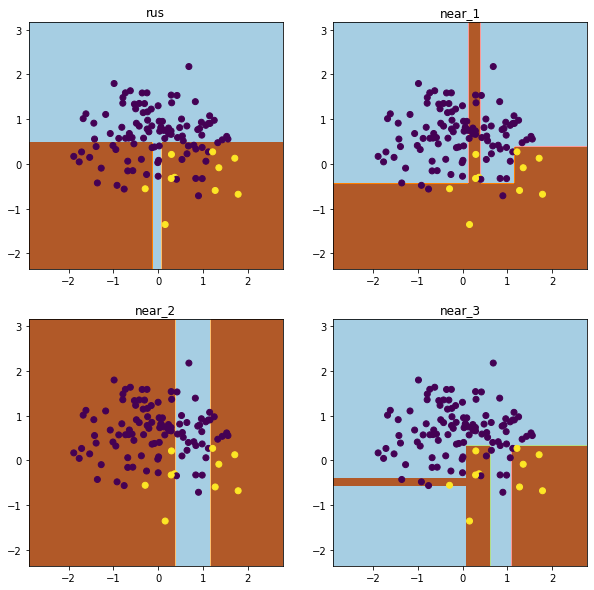

In [101]:
# 시각화
# Train Data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
    ax = axes[idx//2, idx%2]
    under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
    under_Z = under_Z.reshape(xx.shape)
    ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
    ax.scatter(train_data[:,0], train_data[:,1], c=train_label)
    ax.set_title(name)

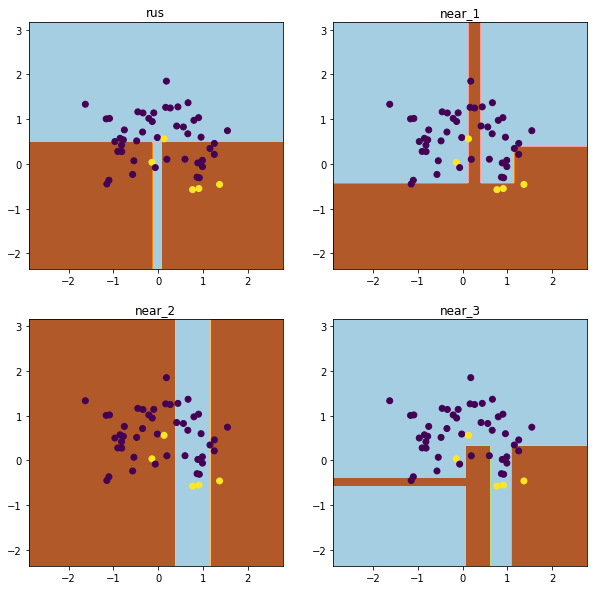

In [102]:
# Test Data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
    ax = axes[idx//2, idx%2]
    under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
    under_Z = under_Z.reshape(xx.shape)
    ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
    ax.scatter(test_data[:,0], test_data[:,1], c=test_label)
    ax.set_title(name)

In [103]:
# Over Sampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2021)

In [104]:
smote_data, smote_label = smote.fit_resample(train_data, train_label)

In [105]:
smote_data[:10]

array([[ 0.022291  ,  0.95240415],
       [ 1.2726705 , -0.59362162],
       [ 0.4805512 ,  0.81069962],
       [ 0.42111578,  1.52899223],
       [-1.52793854,  0.14560623],
       [-0.52990404,  1.33564496],
       [-1.76167925,  0.04472099],
       [ 0.96493371,  0.93040783],
       [-0.67870349,  0.0603892 ],
       [-1.06871775,  0.67797677]])

In [106]:
smote_label[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Text(0.5, 1.0, 'smote data')

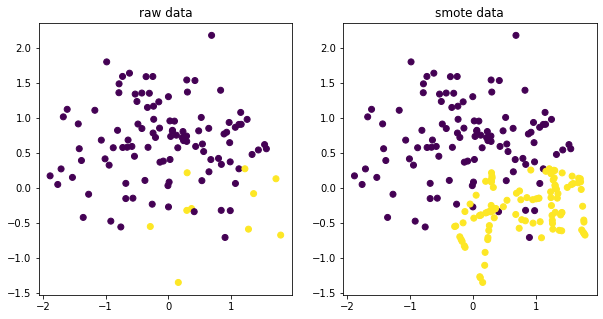

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].scatter(train_data[:, 0], train_data[:, 1], c=train_label)
axes[0].set_title("raw data")

axes[1].scatter(smote_data[:,0], smote_data[:,1], c=smote_label)
axes[1].set_title("smote data")

In [108]:
# 학습
smote_tree = DecisionTreeClassifier()
smote_tree.fit(smote_data, smote_label)

DecisionTreeClassifier()

In [109]:
# 예측
smote_test_pred = smote_tree.predict(test_data)

In [110]:
# 평가
# 정확도
smote_acc = accuracy_score(test_label, smote_test_pred)
print(f"SMOTE test accuray is {smote_acc:.4f}")

SMOTE test accuray is 0.8600


In [111]:
# F1 Score
smote_f1 = f1_score(test_label, smote_test_pred)
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

SMOTE test F1-Score is 0.4615


In [112]:
# 시각화
smote_Z = smote_tree.predict(np.c_[xx.ravel(), yy.ravel()])
smote_Z = smote_Z.reshape(xx.shape)

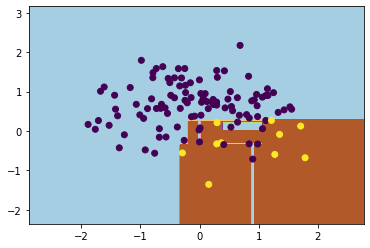

In [113]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)

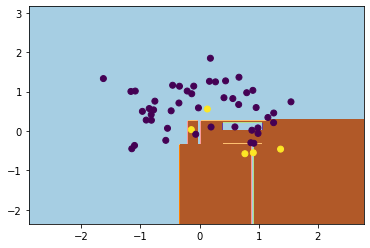

In [114]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:,0], test_data[:,1], c=test_label)

In [115]:
# 비교
# 정확도
print(f"Tree test accuray is {tree_test_acc:.4f}")   
for name, pred in under_pred.items():
    acc = accuracy_score(test_label, pred)
    print(f"{name} Sampling test accuray is {acc:.4f}")
print(f"SMOTE test accuray is {smote_acc:.4f}")

Tree test accuray is 0.9200
rus Sampling test accuray is 0.6200
near_1 Sampling test accuray is 0.8600
near_2 Sampling test accuray is 0.3600
near_3 Sampling test accuray is 0.8400
SMOTE test accuray is 0.8600


In [116]:
# F1 Score
print(f"Tree test F1-Score is {tree_test_f1:.4f}")   
for name, pred in under_pred.items():
    f1 = f1_score(test_label, pred)
    print(f"{name} Sampling test F1-Score is {f1:.4f}")
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

Tree test F1-Score is 0.6000
rus Sampling test F1-Score is 0.2400
near_1 Sampling test F1-Score is 0.4615
near_2 Sampling test F1-Score is 0.1579
near_3 Sampling test F1-Score is 0.2000
SMOTE test F1-Score is 0.4615


In [117]:
# SMOTE 방법의 정확도와 F1 Score가 Tree보다 안 좋게 나왔다...